# Stock trend classification (2.2/3): train InceptionTime

InceptionTime paper:
https://arxiv.org/pdf/1909.04939.pdf

### Load datasets

In [1]:
import numpy as np
import pandas as pd

CLASSES = ['Bull', 'Bear']
LABEL_BULL = CLASSES.index('Bull')
LABEL_BEAR = CLASSES.index('Bear')

datasets = np.load('datasets.npz')
x_train, y_train = datasets['x_train'], datasets['y_train']
x_val, y_val = datasets['x_val'], datasets['y_val']
x_test, y_test = datasets['x_test'], datasets['y_test']

# Label distribution
label_distribution = pd.DataFrame([{'Dataset': 'train',
                                    'Bull': np.count_nonzero(y_train == LABEL_BULL),
                                    'Bear': np.count_nonzero(y_train == LABEL_BEAR)},
                                   {'Dataset': 'val',
                                    'Bull': np.count_nonzero(y_val == LABEL_BULL),
                                    'Bear': np.count_nonzero(y_val == LABEL_BEAR)},
                                   {'Dataset': 'test',
                                    'Bull': np.count_nonzero(y_test == LABEL_BULL),
                                    'Bear': np.count_nonzero(y_test == LABEL_BEAR)}])
label_distribution

,Dataset,Bull,Bear
0,train,827,828
1,val,237,236
2,test,107,107


### Construct model

In [7]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Concatenate, \
                                    BatchNormalization, Activation, \
                                    Add, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model

def inception_module(input_tensor):
    bottleneck = Conv1D(filters=32, kernel_size=1, padding='same', activation=None,
                        use_bias=False)(input_tensor)
    conv3 = Conv1D(filters=32, kernel_size=3, padding='same', activation=None,
                   use_bias=False)(bottleneck)
    conv5 = Conv1D(filters=32, kernel_size=5, padding='same', activation=None,
                   use_bias=False)(bottleneck)
    conv7 = Conv1D(filters=32, kernel_size=7, padding='same', activation=None,
                   use_bias=False)(bottleneck)
    mp = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_tensor)
    mpbottleneck = Conv1D(filters=32, kernel_size=1, padding='same', activation=None,
                          use_bias=False)(mp)
    
    x = Concatenate(axis=-1)([conv3, conv5, conv7, mpbottleneck])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def shortcut_layer(input_tensor1, input_tendor2):
    shortcut = Conv1D(filters=input_tendor2.shape[-1], kernel_size=1, padding='same',
                      activation=None, use_bias=False)(input_tensor1)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, input_tendor2])
    x = Activation('relu')(x)
    return x

# Build model
n_time_steps = x_train.shape[1]
n_features = x_train.shape[2]

input_layer = Input(shape=(n_time_steps, n_features))
x = input_layer
input_residual = input_layer

for i in range(6):
    x = inception_module(x)

    if i % 3 == 2:
        x = shortcut_layer(input_residual, x)
        input_residual = x

x = GlobalAveragePooling1D()(x)
output_layer = Dense(len(CLASSES), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 100, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_65 (Conv1D)  │ (None, 100, 32)   │        160 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 100, 5)    │          0 │ input_layer_3[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, 100, 32)   │      3,072 │ conv1d_65[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_67 (Conv1D)  │ (None, 100, 32)   │      5,120 │ conv1d_65[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 100, 32)   │      7,168 │ conv1d_65[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_69 (Conv1D)  │ (None, 100, 32)   │        160 │ max_pooling1d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 100, 128)  │          0 │ conv1d_66[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_67[0][0],  │
│                     │                   │            │ conv1d_68[0][0],  │
│                     │                   │            │ conv1d_69[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ concatenate_12[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 100, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_70 (Conv1D)  │ (None, 100, 32)   │      4,096 │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 100, 128)  │          0 │ activation_16[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_71 (Conv1D)  │ (None, 100, 32)   │      3,072 │ conv1d_70[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_72 (Conv1D)  │ (None, 100, 32)   │      5,120 │ conv1d_70[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_73 (Conv1D)  │ (None, 100, 32)   │      7,168 │ conv1d_70[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_74 (Conv1D)  │ (None, 100, 32)   │      4,096 │ max_pooling1d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 100, 128)  │          0 │ conv1d_71[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_72[0][0],  │
│                     │                   │            │ conv1d_73[0][0],  │
│                     │                   │            │ conv1d_74[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 128)  │        512 │ concatenate_13[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 100, 128)  │          0 │ batch_normalizat

 Total params: 154,818 (604.76 KB)

 Trainable params: 152,770 (596.76 KB)

 Non-trainable params: 2,048 (8.00 KB)

### Train model

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss',
                                   save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
callbacks = [model_checkpoint, early_stopping]

train_history = model.fit(x_train, to_categorical(y_train),
                          validation_data=(x_val, to_categorical(y_val)),
                          batch_size=2048, epochs=1000, callbacks=[callbacks])

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.4991 - loss: 0.7289 - val_accuracy: 0.4989 - val_loss: 12.0883
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5239 - loss: 0.7577 - val_accuracy: 0.4989 - val_loss: 8.7386
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5239 - loss: 0.7060 - val_accuracy: 0.4989 - val_loss: 3.4899
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5239 - loss: 0.6932 - val_accuracy: 0.4989 - val_loss: 1.4531
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5021 - loss: 0.7004 - val_accuracy: 0.4989 - val_loss: 1.6716
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4979 - loss: 0.6975 - val_accuracy: 0.4989 - val_loss: 2.8023
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5366 - loss: 0.6898 - val_accuracy: 0.4989 - val_loss: 3.9724
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5450 - loss: 0.6869 - val_accuracy: 0.4989 - val_loss: 4.4912

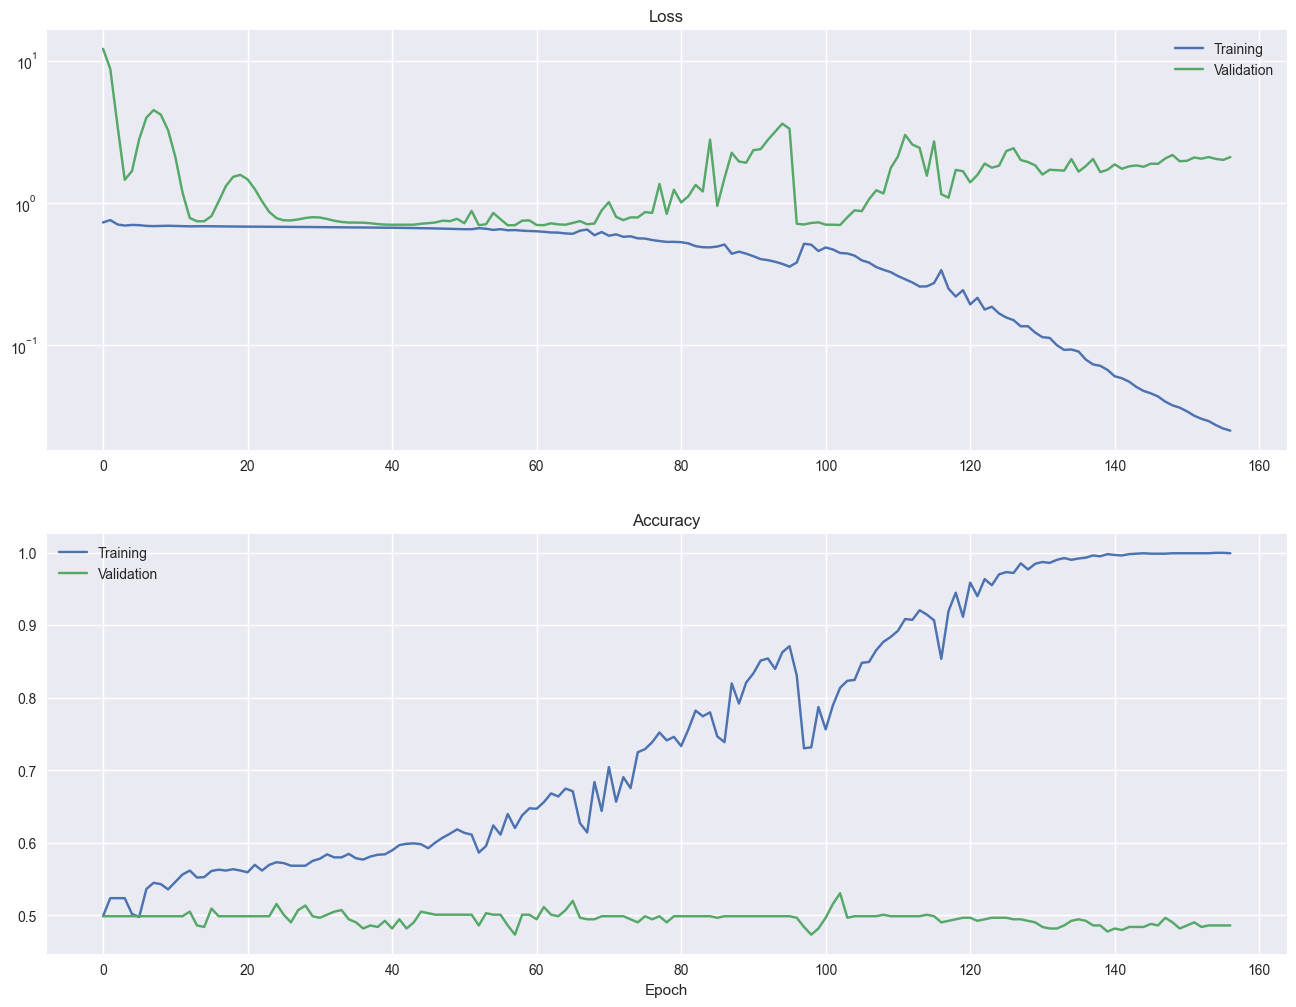

In [9]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

axes[0].set_title('Loss')
axes[0].set_yscale('log')
axes[0].plot(train_history.history['loss'], label='Training')
axes[0].plot(train_history.history['val_loss'], label='Validation')
axes[0].legend()

axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].plot(train_history.history['accuracy'], label='Training')
axes[1].plot(train_history.history['val_accuracy'], label='Validation')
axes[1].legend()